In [1]:
import os
print(os.getcwd())
if os.getcwd().endswith("combined"):
    os.chdir("..")
    os.chdir("..")
print(os.getcwd())
from src.modelling import DeepModel_Trainer
from src.augmentation import Transformer,None_Transform
from src.data_modules import DataModule,ImagesDataset
from torch import nn
import torch
from torchvision import transforms,models
import nibabel as nib
import numpy as np
from src.evaluation import Evaluation
import os, sys
sys.path.insert(0, '..')
import numpy as np
from NODE import arch,odst,nn_utils
import torch, torch.nn as nn

/mnt/batch/tasks/shared/LS_root/mounts/clusters/ksajazwi-cpu/code/Users/pro5d-classification-prolactinoma/modelling/combined
/mnt/batch/tasks/shared/LS_root/mounts/clusters/ksajazwi-cpu/code/Users/pro5d-classification-prolactinoma


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torch/cuda/__init__.py:740: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


## Multimodal

In [9]:
%env "WANDB_NOTEBOOK_NAME" "baseline"
%env WANDB_SILENT=True

base_transformer = Transformer(
    None_Transform(), "select_roi"
)


class FusionModel(nn.Module):
    def __init__(self):
        super(FusionModel, self).__init__()
        self.shallow_node_model = self.shallow_NODE()
        self.mlp = self.base_mlp()
        
        # Define the MLP that takes 4048 input features and outputs 1 feature
        self.final_mlp = nn.Sequential(
            nn.Linear(4096, 1024),  # Example: intermediate layer with 1024 neurons
            nn.ReLU(),
            nn.Linear(1024, 1)  # Final layer with 1 neuron
        )

    def forward(self, image,tabular_data):
        # Apply the shallow_NODE and base_mlp models
        output1 = self.shallow_node_model(tabular_data)
        output2 = self.mlp(image)
        
        combined = torch.cat((output1, output2), dim=1)

        # Pass the combined output through the final MLP
        result = self.final_mlp(combined)
        return result
    
    def shallow_NODE(self):
        model = nn.Sequential(
        arch.DenseBlock(4, 2048, num_layers=1, tree_dim=3, depth=6, flatten_output=False,
                    choice_function=nn_utils.entmax15, bin_function=nn_utils.entmoid15),
                    nn_utils.Lambda(lambda x: x.mean(dim=-1)),  # average first channels of every tree
        )
        return model
    def base_mlp(self):
        model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            75264, 2048
        )) 
        return model

env: "WANDB_NOTEBOOK_NAME"="baseline"
env: WANDB_SILENT=True


Fold-Iteration:   0%|          | 0/1 [00:00<?, ?fold/s]

{'index_batch': 1, 'epoch': 0, 'loss batch': tensor(0.6480, grad_fn=<BinaryCrossEntropyBackward0>)}


Epoch-Iteration: 100%|██████████| 1/1 [00:31<00:00, 31.61s/epoch]

{'epoch': 0, 'Loss train': 0.6479511260986328, 'Loss val': tensor(19.7531, dtype=torch.float64), 'sensitivity_val': 0.0, 'specificity_val': 1.0, 'auc_val': 0.5, 'sensitivity_train': 0.0, 'specificity_train': 1.0, 'auc_train': 0.5}
{'sensitivity eval': 0.0, 'specificity eval': 1.0, 'auc eval': 0.5}


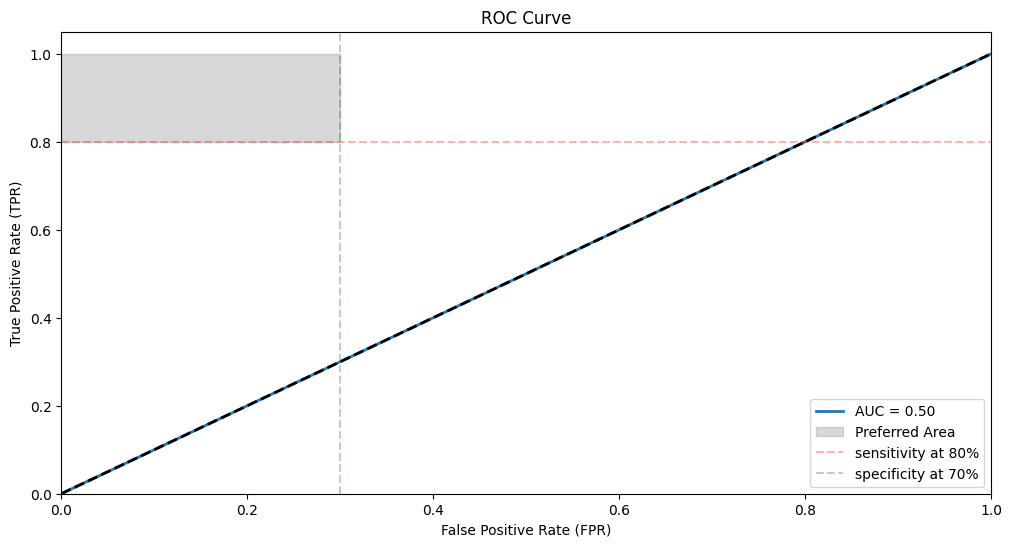

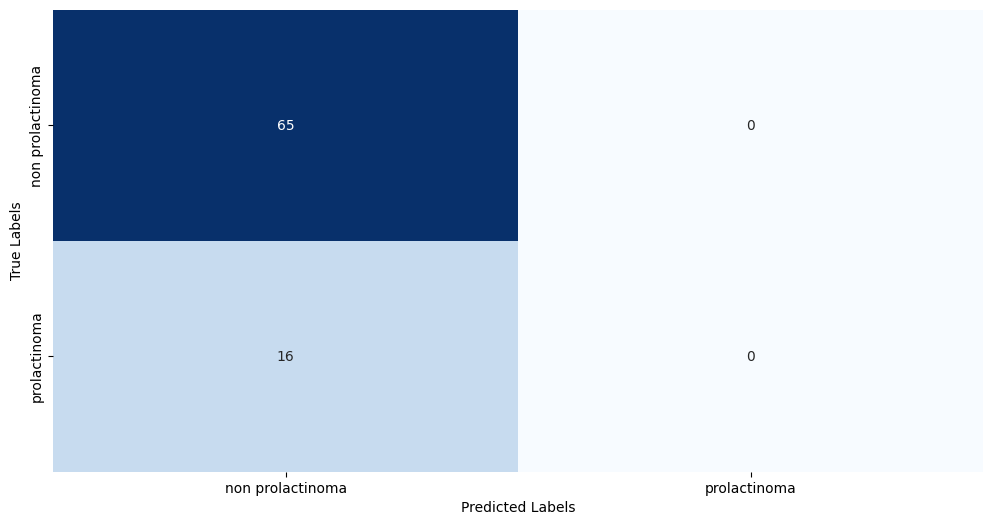

Fold-Iteration: 100%|██████████| 1/1 [00:35<00:00, 35.68s/fold]

{'index false positiv eval': array([], dtype=int64), 'index false negativ eval': array([ 4, 10, 12, 23, 26]), 'index true positiv eval': array([], dtype=int64), 'index true negativ eval': array([0, 1, 2, 3, 5])}


In [11]:

data_module = DataModule(base_transformer,use_mri_images=True,use_tabular_data=True,columns_tab_data=["COR60","FSH","FT4","IGF1"])
baseline = DeepModel_Trainer(data_module, FusionModel)
baseline.train_model("Baseline MLP", "base_mlp", num_epochs=1, test_model=True,batchsize_train_data=10,use_mri_images=True,use_tabular_data=True,num_workers=0,
                    save_model=False,
                    cross_validation=False,lr=0.005,evaluate_test_set=False)